# Maximum Likelihood Estimation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numpy import exp
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.api import Poisson
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col

### Counting Billionaires

Treisman [[Tre16](https://python.quantecon.org/zreferences.html#id92)] is interested in estimating the number of billionaires in different countries.

The number of billionaires is integer-valued.

Hence we consider distributions that take values only in the nonnegative integers.

(This is one reason least squares regression is not the best tool for the present problem, since the dependent variable in linear regression is not restricted
to integer values)

One integer distribution is the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), the probability mass function (pmf) of which is

$$
f(y) = \frac{\mu^{y}}{y!} e^{-\mu},
\qquad y = 0, 1, 2, \ldots, \infty
$$

We can plot the Poisson distribution over $ y $ for different values of $ \mu $ as follows

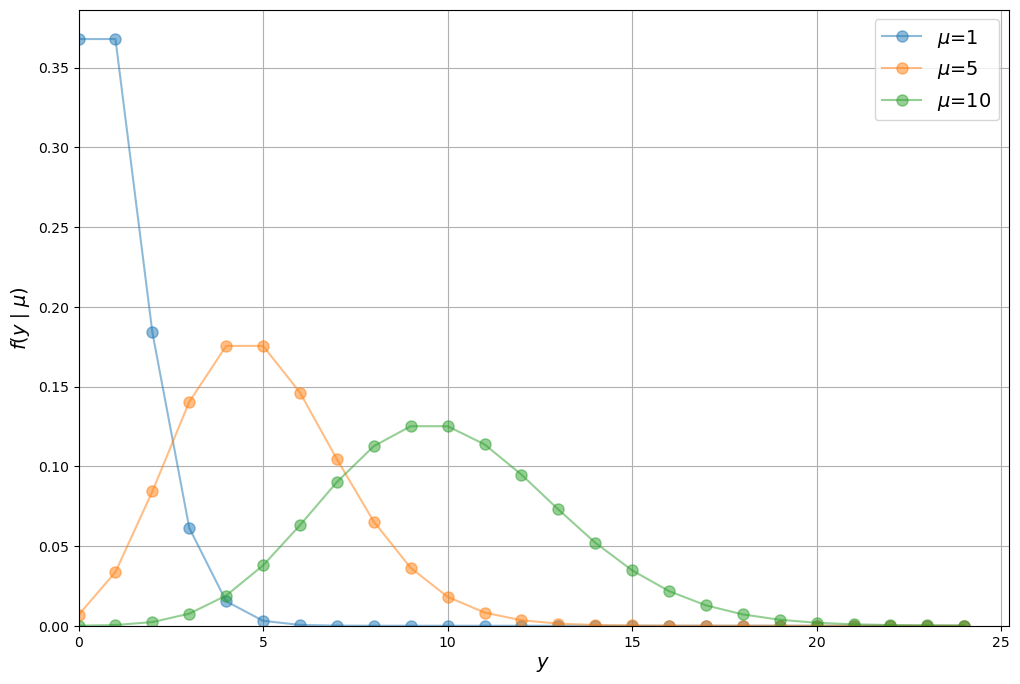

In [2]:
poisson_pmf = lambda y, μ: μ**y / factorial(y) * exp(-μ)
y_values = range(0, 25)

fig, ax = plt.subplots(figsize=(12, 8))

for μ in [1, 5, 10]:
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=f'$\mu$={μ}',
            alpha=0.5,
            marker='o',
            markersize=8)

ax.grid()
ax.set_xlabel('$y$', fontsize=14)
ax.set_ylabel('$f(y \mid \mu)$', fontsize=14)
ax.axis(xmin=0, ymin=0)
ax.legend(fontsize=14)

plt.show()

Notice that the Poisson distribution begins to resemble a normal distribution as the mean of $ y $ increases.

Let’s have a look at the distribution of the data we’ll be working with in this lecture.

Treisman’s main source of data is *Forbes’* annual rankings of billionaires and their estimated net worth.

The dataset `mle/fp.dta` can be downloaded from [here](https://python.quantecon.org/_static/lecture_specific/mle/fp.dta)
or its [AER page](https://www.aeaweb.org/articles?id=10.1257/aer.p20161068).

In [3]:
pd.options.display.max_columns = 10

# Load in data and view
df = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/mle/fp.dta?raw=true')
df.head()

,country,ccode,year,cyear,numbil,...,topint08,rintr,noyrs,roflaw,nrrents
0,United States,2.0,1990.0,21990.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
1,United States,2.0,1991.0,21991.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
2,United States,2.0,1992.0,21992.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
3,United States,2.0,1993.0,21993.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
4,United States,2.0,1994.0,21994.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN


Using a histogram, we can view the distribution of the number of
billionaires per country, `numbil0`, in 2008 (the United States is
dropped for plotting purposes)

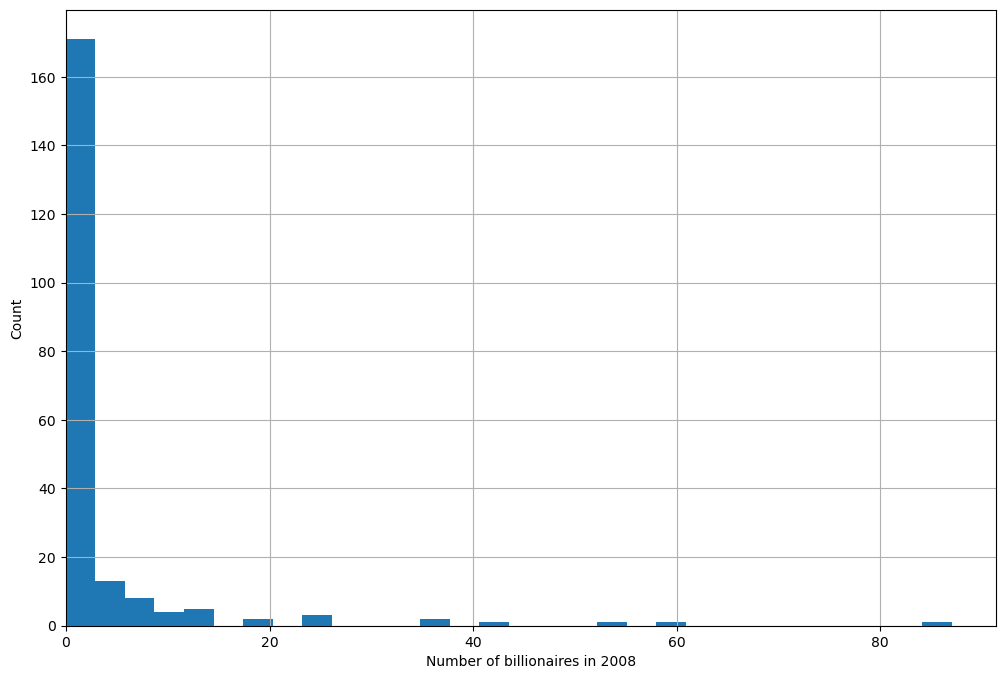

In [4]:
numbil0_2008 = df[(df['year'] == 2008) & (
    df['country'] != 'United States')].loc[:, 'numbil0']

plt.subplots(figsize=(12, 8))
plt.hist(numbil0_2008, bins=30)
plt.xlim(left=0)
plt.grid()
plt.xlabel('Number of billionaires in 2008')
plt.ylabel('Count')
plt.show()

From the histogram, it appears that the Poisson assumption is not unreasonable (albeit with a very low $ \mu $ and some outliers).

## Conditional Distributions

In Treisman’s paper, the dependent variable — the number of billionaires $ y_i $ in country $ i $ — is modeled as a function of GDP per capita, population size, and years membership in GATT and WTO.

Hence, the distribution of $ y_i $ needs to be conditioned on the vector of explanatory variables $ \mathbf{x}_i $.

The standard formulation — the so-called *poisson regression* model — is as follows:


<a id='equation-poissonreg'></a>
$$
f(y_i \mid \mathbf{x}_i) = \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}; \qquad y_i = 0, 1, 2, \ldots , \infty . \tag{79.1}
$$

$$
\text{where}\ \mu_i
     = \exp(\mathbf{x}_i' \boldsymbol{\beta})
     = \exp(\beta_0 + \beta_1 x_{i1} + \ldots + \beta_k x_{ik})
$$

To illustrate the idea that the distribution of $ y_i $ depends on
$ \mathbf{x}_i $ let’s run a simple simulation.

We use our `poisson_pmf` function from above and arbitrary values for
$ \boldsymbol{\beta} $ and $ \mathbf{x}_i $

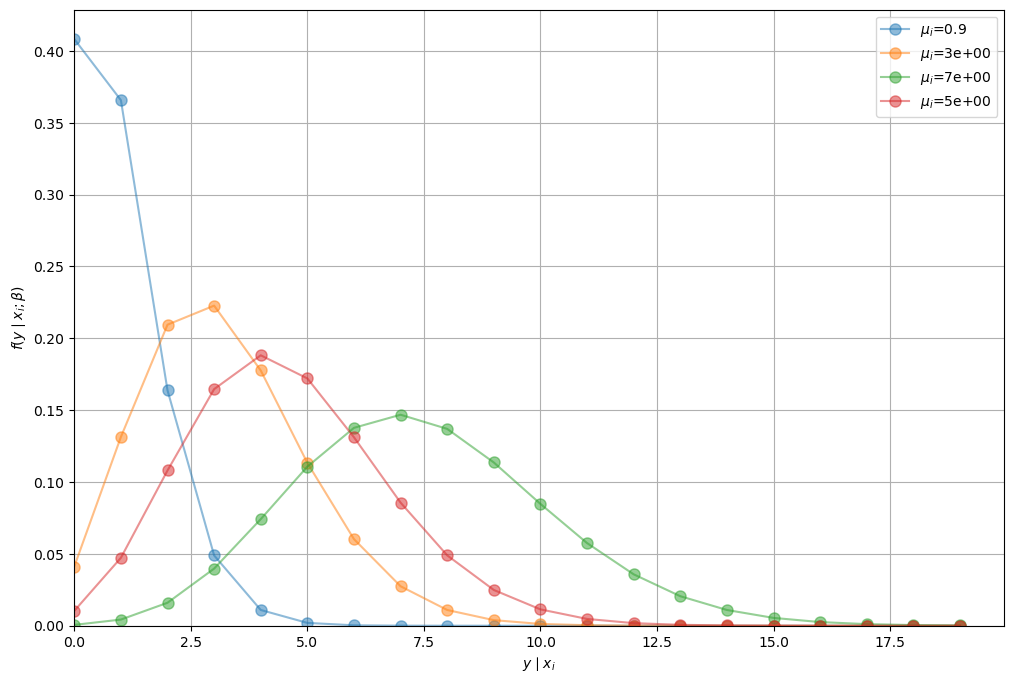

In [5]:
y_values = range(0, 20)

# Define a parameter vector with estimates
β = np.array([0.26, 0.18, 0.25, -0.1, -0.22])

# Create some observations X
datasets = [np.array([0, 1, 1, 1, 2]),
            np.array([2, 3, 2, 4, 0]),
            np.array([3, 4, 5, 3, 2]),
            np.array([6, 5, 4, 4, 7])]


fig, ax = plt.subplots(figsize=(12, 8))

for X in datasets:
    μ = exp(X @ β)
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=f'$\mu_i$={μ:.1}',
            marker='o',
            markersize=8,
            alpha=0.5)

ax.grid()
ax.legend()
ax.set_xlabel('$y \mid x_i$')
ax.set_ylabel(r'$f(y \mid x_i; \beta )$')
ax.axis(xmin=0, ymin=0)
plt.show()

We can see that the distribution of $ y_i $ is conditional on
$ \mathbf{x}_i $ ($ \mu_i $ is no longer constant).

## Maximum Likelihood Estimation

In our model for number of billionaires, the conditional distribution
contains 4 ($ k = 4 $) parameters that we need to estimate.

We will label our entire parameter vector as $ \boldsymbol{\beta} $ where

$$
\boldsymbol{\beta} = \begin{bmatrix}
                            \beta_0 \\
                            \beta_1 \\
                            \beta_2 \\
                            \beta_3
                      \end{bmatrix}
$$

To estimate the model using MLE, we want to maximize the likelihood that
our estimate $ \hat{\boldsymbol{\beta}} $ is the true parameter $ \boldsymbol{\beta} $.

Intuitively, we want to find the $ \hat{\boldsymbol{\beta}} $ that best fits our data.

First, we need to construct the likelihood function $ \mathcal{L}(\boldsymbol{\beta}) $, which is similar to a joint probability density function.

Assume we have some data $ y_i = \{y_1, y_2\} $ and
$ y_i \sim f(y_i) $.

If $ y_1 $ and $ y_2 $ are independent, the joint pmf of these
data is $ f(y_1, y_2) = f(y_1) \cdot f(y_2) $.

If $ y_i $ follows a Poisson distribution with $ \lambda = 7 $,
we can visualize the joint pmf like so

Similarly, the joint pmf of our data (which is distributed as a
conditional Poisson distribution) can be written as

$$
f(y_1, y_2, \ldots, y_n \mid \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n; \boldsymbol{\beta})
    = \prod_{i=1}^{n} \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}
$$

$ y_i $ is conditional on both the values of $ \mathbf{x}_i $ and the
parameters $ \boldsymbol{\beta} $.

The likelihood function is the same as the joint pmf, but treats the
parameter $ \boldsymbol{\beta} $ as a random variable and takes the observations
$ (y_i, \mathbf{x}_i) $ as given

$$
\begin{split}
\mathcal{L}(\beta \mid y_1, y_2, \ldots, y_n \ ; \ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n) = &
\prod_{i=1}^{n} \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i} \\ = &
f(y_1, y_2, \ldots, y_n \mid  \ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n ; \beta)
\end{split}
$$

Now that we have our likelihood function, we want to find the $ \hat{\boldsymbol{\beta}} $ that yields the maximum likelihood value

$$
\underset{\boldsymbol{\beta}}{\max} \mathcal{L}(\boldsymbol{\beta})
$$

In doing so it is generally easier to maximize the log-likelihood (consider
differentiating $ f(x) = x \exp(x) $  vs.  $ f(x) = \log(x) + x $).

Given that taking a logarithm is a monotone increasing transformation, a maximizer of the likelihood function will also be a maximizer of the log-likelihood function.

In our case the log-likelihood is

$$
\begin{split}
\log{ \mathcal{L}} (\boldsymbol{\beta}) = \ &
    \log \Big(
        f(y_1 ; \boldsymbol{\beta})
        \cdot
        f(y_2 ; \boldsymbol{\beta})
        \cdot \ldots \cdot
        f(y_n ; \boldsymbol{\beta})
        \Big) \\
        = &
        \sum_{i=1}^{n} \log{f(y_i ; \boldsymbol{\beta})} \\
        = &
        \sum_{i=1}^{n}
        \log \Big( {\frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}} \Big) \\
        = &
        \sum_{i=1}^{n} y_i \log{\mu_i} -
        \sum_{i=1}^{n} \mu_i -
        \sum_{i=1}^{n} \log y!
\end{split}
$$

The MLE of the Poisson to the Poisson  for $ \hat{\beta} $ can be obtained by solving

$$
\underset{\beta}{\max} \Big(
\sum_{i=1}^{n} y_i \log{\mu_i} -
\sum_{i=1}^{n} \mu_i -
\sum_{i=1}^{n} \log y! \Big)
$$

However, no analytical solution exists to the above problem – to find the MLE
we need to use numerical methods.

## Maximum Likelihood Estimation with `statsmodels`

Now that we know what’s going on under the hood, we can apply MLE to an interesting application.

We’ll use the Poisson regression model in `statsmodels` to obtain
a richer output with standard errors, test values, and more.

`statsmodels` uses the same algorithm as above to find the maximum
likelihood estimates.

Before we begin, let’s re-estimate our simple model with `statsmodels`
to confirm we obtain the same coefficients and log-likelihood value.

In [13]:
X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

stats_poisson = Poisson(y, X).fit()
print(stats_poisson.summary())

Optimization terminated successfully.
         Current function value: 0.675671
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                    5
Model:                        Poisson   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:                  0.2546
Time:                        17:48:39   Log-Likelihood:                -3.3784
converged:                       True   LL-Null:                       -4.5325
Covariance Type:            nonrobust   LLR p-value:                    0.3153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0785      5.279     -1.151      0.250     -16.425       4.268
x1             0.9334      0.

Now let’s replicate results from Daniel Treisman’s paper, [Russia’s
Billionaires](https://www.aeaweb.org/articles?id=10.1257/aer.p20161068),
mentioned earlier in the lecture.

Treisman starts by estimating equation [(79.1)](#equation-poissonreg), where:

- $ y_i $ is $ {number\ of\ billionaires}_i $  
- $ x_{i1} $ is $ \log{GDP\ per\ capita}_i $  
- $ x_{i2} $ is $ \log{population}_i $  
- $ x_{i3} $ is $ {years\ in\ GATT}_i $ – years membership in GATT and WTO (to proxy access to international markets)  


The paper only considers the year 2008 for estimation.

We will set up our variables for estimation like so (you should have the
data assigned to `df` from earlier in the lecture)

In [14]:
# Keep only year 2008
df = df[df['year'] == 2008]

# Add a constant
df['const'] = 1

# Variable sets
reg1 = ['const', 'lngdppc', 'lnpop', 'gattwto08']
reg2 = ['const', 'lngdppc', 'lnpop',
        'gattwto08', 'lnmcap08', 'rintr', 'topint08']
reg3 = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08',
        'rintr', 'topint08', 'nrrents', 'roflaw']

Then we can use the `Poisson` function from `statsmodels` to fit the
model.

We’ll use robust standard errors as in the author’s paper

In [15]:
# Specify model
poisson_reg = sm.Poisson(df[['numbil0']], df[reg1],
                         missing='drop').fit(cov_type='HC0')
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:                  0.8574
Time:                        17:48:39   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000     -34.103     -23.997
lngdppc        1.0839      0.

Success! The algorithm was able to achieve convergence in 9 iterations.

Our output indicates that GDP per capita, population, and years of
membership in the General Agreement on Tariffs and Trade (GATT) are
positively related to the number of billionaires a country has, as
expected.

Let’s also estimate the author’s more full-featured models and display
them in a single table

In [16]:
regs = [reg1, reg2, reg3]
reg_names = ['Model 1', 'Model 2', 'Model 3']
info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['const',
                   'lngdppc',
                   'lnpop',
                   'gattwto08',
                   'lnmcap08',
                   'rintr',
                   'topint08',
                   'nrrents',
                   'roflaw']
results = []

for reg in regs:
    result = sm.Poisson(df[['numbil0']], df[reg],
                        missing='drop').fit(cov_type='HC0',
                                            maxiter=100, disp=0)
    results.append(result)

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('Table 1 - Explaining the Number of Billionaires \
                        in 2008')
print(results_table)

Table 1 - Explaining the Number of Billionaires                         in 2008
                  Model 1    Model 2    Model 3  
-------------------------------------------------
const            -29.050*** -19.444*** -20.858***
                 (2.578)    (4.820)    (4.255)   
lngdppc          1.084***   0.717***   0.737***  
                 (0.138)    (0.244)    (0.233)   
lnpop            1.171***   0.806***   0.929***  
                 (0.097)    (0.213)    (0.195)   
gattwto08        0.006      0.007      0.004     
                 (0.007)    (0.006)    (0.006)   
lnmcap08                    0.399**    0.286*    
                            (0.172)    (0.167)   
rintr                       -0.010     -0.009    
                            (0.010)    (0.010)   
topint08                    -0.051***  -0.058*** 
                            (0.011)    (0.012)   
nrrents                                -0.005    
                                       (0.010)   
roflaw              

The output suggests that the frequency of billionaires is positively
correlated with GDP per capita, population size, stock market
capitalization, and negatively correlated with top marginal income tax
rate.

To analyze our results by country, we can plot the difference between
the predicted an actual values, then sort from highest to lowest and
plot the first 15

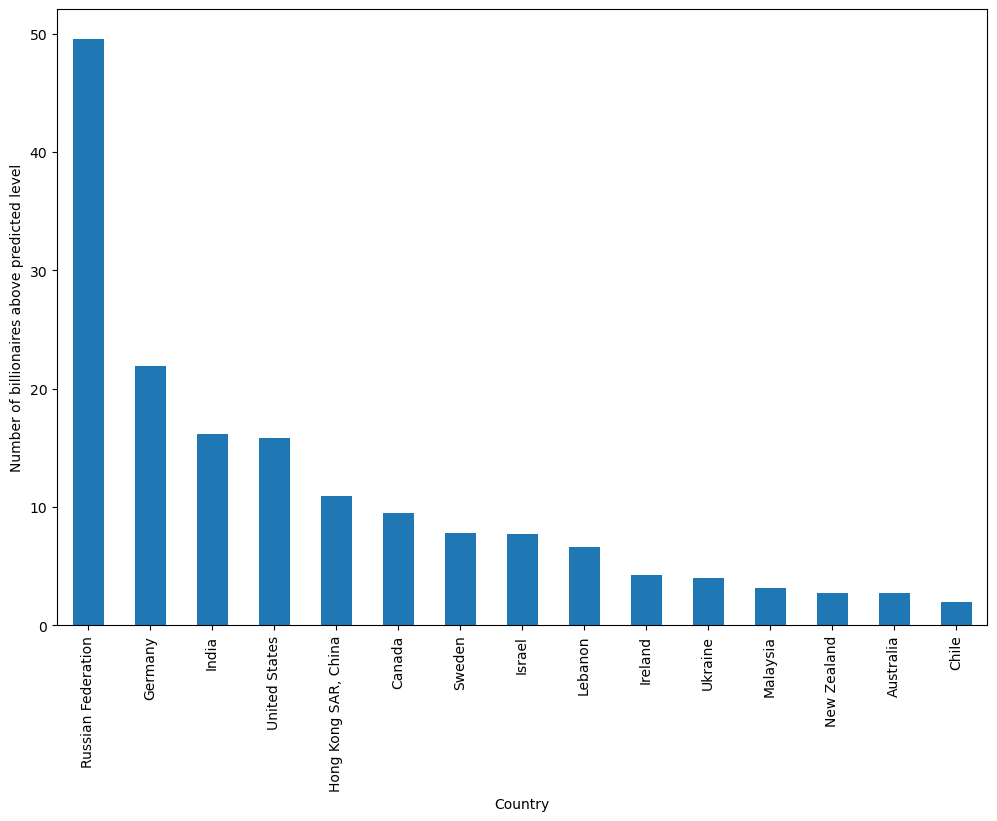

In [17]:
data = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08', 'rintr',
        'topint08', 'nrrents', 'roflaw', 'numbil0', 'country']
results_df = df[data].dropna()

# Use last model (model 3)
results_df['prediction'] = results[-1].predict()

# Calculate difference
results_df['difference'] = results_df['numbil0'] - results_df['prediction']

# Sort in descending order
results_df.sort_values('difference', ascending=False, inplace=True)

# Plot the first 15 data points
results_df[:15].plot('country', 'difference', kind='bar',
                    figsize=(12,8), legend=False)
plt.ylabel('Number of billionaires above predicted level')
plt.xlabel('Country')
plt.show()

As we can see, Russia has by far the highest number of billionaires in
excess of what is predicted by the model (around 50 more than expected).

Treisman uses this empirical result to discuss possible reasons for
Russia’s excess of billionaires, including the origination of wealth in
Russia, the political climate, and the history of privatization in the
years after the USSR.

## Summary

In this lecture, we used Maximum Likelihood Estimation to estimate the
parameters of a Poisson model.

`statsmodels` contains other built-in likelihood models such as
[Probit](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Probit.html)
and
[Logit](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html).

For further flexibility, `statsmodels` provides a way to specify the
distribution manually using the `GenericLikelihoodModel` class - an
example notebook can be found
[here](https://www.statsmodels.org/dev/examples/notebooks/generated/generic_mle.html).